In [1]:
import subprocess
import json

#Configure Clingo parameters

clingo_path = 'C:\\Users\\lenovo\\Documents\\MSc Computer Science\\ASP\\clingo.exe'
clingo_options = ['--outf=2','-n 0']
clingo_command = [clingo_path] + clingo_options

#Solve the ruleset.
def solve(program):
    input = program.encode()
    process = subprocess.Popen(clingo_command, stdin=subprocess.PIPE, stderr=subprocess.PIPE, stdout=subprocess.PIPE)
    output, error = process.communicate(input)
    result = json.loads(output.decode())
    if result['Result'] == 'SATISFIABLE':
        return [value['Value'] for value in result['Call'][0]['Witnesses']]
    else:
        return None

In [2]:
def write_problem(constraints):
    all_rules = [['rules\\kick_placement.lp', 'rules\\kick_con_1.lp', 'rules\\kick_con_2.lp'], \
                 ['rules\\snare_placement_exp.lp', 'rules\\snare_placement_conv.lp'], \
                 ['rules\\kick_snare_con_1.lp'], \
                 ['rules\\hat_placement_exp.lp', 'rules\\hat_placement_conv.lp' , 'rules\\hat_con_1.lp', 'rules\\hat_con_2.lp'], \
                 ['rules\\perc_placement.lp', 'rules\\perc_con_1.lp', 'rules\\perc_con_2.lp'], \
                 ['rules\\gsnare_placement.lp', 'rules\\gsnare_con_1.lp', 'rules\\gsnare_con_2.lp']]
    rules = ['rules\\time.lp']
    i = 0
    for row in all_rules:
        for j in range(0, len(row)):
            if constraints[i][j]:
                rules.append(all_rules[i][j])
        i += 1
    with open('rules\\problem.lp', 'w') as outfile:
        for fname in rules:
            with open(fname) as infile:
                outfile.write(infile.read())    

In [3]:
#Solve the problem in Clingo, specifying what kind of pattern will be generated.
#Print the number of solutions.
def generate_solutions(constraints, user_input):
    write_problem(constraints)
    if user_input:     
        with open('rules\\problem.lp', 'a') as outfile:
            outfile.write('\n'.join(user_input) + '\n')
    problem = open('rules\\problem.lp', 'r').read()
    solutions = solve(problem)
    #Print the number of patterns found.
    print(str(len(solutions)) + " one bar patterns have been found.\n")

    return solutions

In [4]:
#Represent hit_list as a table.

import numpy as np
import matplotlib.pyplot as plt
#import random
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FixedLocator

def print_hits(pattern_index, hit_list, pattern_length = 1):

    X = np.ones((5, 16 * pattern_length))

    for i in hit_list:
        if i[0] == 'k':
            X[4][int(i[1])-1] = 0
        if i[0] == 's':
            X[3][int(i[1])-1] = 0.2
        if i[0] == 'g':
            X[2][int(i[1])-1] = 0.4
        if i[0] == 'h':
            X[1][int(i[1])-1] = 0.6
        if i[0] == 'p':
            X[0][int(i[1])-1] = 0.8

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(X, cmap=plt.get_cmap('gray'))

    y_labels = ['Percussion', 'Hat', 'Ghost Snare', 'Snare', 'Kick']
    ax.set_xticks(list(range(0, 16 * pattern_length)))
    ax.set_yticks(list(range(0, 5)))
    ax.set_yticklabels(y_labels)
    ax.set_xticklabels(list(range(1, 16 * pattern_length + 1)))
    
    minor_xlocator = AutoMinorLocator(2)
    minor_ylocator = FixedLocator([x + 0.5 for x in range(0, 16 * pattern_length)])
    ax.xaxis.set_minor_locator(minor_xlocator)
    ax.yaxis.set_minor_locator(minor_ylocator)
    ax.grid(which='minor', color='0.4', linestyle='dashed')
    ax.set_title("Pattern " + str(pattern_index), fontsize=18)

    plt.show()

In [9]:
#Create MIDI representation of the drum pattern.

from midiutil import MIDIFile

#offset needed to convert to MIDI time.
offset = 0.25
track    = 0
channel  = 0
duration = 0.125 # In beats
tempo    = 174  # In BPM
volume   = 100  # 0-127, as per the MIDI standard

#Write a MIDI file for a set of hits with a given file name.
def write_midi(hit_list, file_name, humanisation_intensity = 0):
    MyMIDI = MIDIFile(1)  # One track, defaults to format 1 (tempo track is created
                          # automatically)
    MyMIDI.addTempo(track, 0, tempo)
    
    #humanisation value to randomly nudge hits around and change velocity.
    #The further away from 0 the hit is nudged, the quieter it is hit.
    humanisation = np.random.normal(0, humanisation_intensity, len(hit_list))
    humanisation[0] = 0

    #iterator
    j = 0
    #Add kicks to middle C, snares to C#3 and hats to D3.
    for i in hit_list:
        if i[0] == 'k':
            MyMIDI.addNote(track, channel, 60, float(i[1])/4-offset+humanisation[j], duration, int(volume-abs(humanisation[j])*300))
        if i[0] == 's':
            MyMIDI.addNote(track, channel, 61, float(i[1])/4-offset+humanisation[j], duration, int(volume-abs(humanisation[j])*300))
        if i[0] == 'g':
            MyMIDI.addNote(track, channel, 61, float(i[1])/4-offset+humanisation[j], duration, int(40-abs(humanisation[j])*300))
        if i[0] == 'h':
            MyMIDI.addNote(track, channel, 62, float(i[1])/4-offset+humanisation[j], duration, int(volume-abs(humanisation[j])*300))
        if i[0] == 'p':
            MyMIDI.addNote(track, channel, 63, float(i[1])/4-offset+humanisation[j], duration, int(volume-abs(humanisation[j])*300))
        j += 1
            
    with open(file_name, "wb") as output_file:
        MyMIDI.writeFile(output_file)

In [16]:
def extend_pattern(pattern, extended_length):
    two_bar_rules = ['rules\\time.lp', 'rules\\kick_snare_con_1.lp', 'rules\\hat_con_1.lp', 'rules\\hat_con_2.lp', 'rules\\perc_con_1.lp', 'rules\\perc_con_2.lp', 'rules\\gsnare_con_1.lp', 'rules\\gsnare_con_2.lp', 'rules\\extend_to_2_bars.lp']
    with open('rules\\problem_2_bar.lp', 'w') as outfile:
        for fname in two_bar_rules:
            with open(fname) as infile:
                outfile.write(infile.read())
    
    with open('rules\\problem_2_bar.lp', 'a') as outfile:
        outfile.write('\n'.join([hit + '.' for hit in pattern]) + '\n')
    
    problem = open('rules\\problem_2_bar.lp', 'r').read()
    solutions = solve(problem)
    #Return if no valid solutions are found to allow another attempt.
    if solutions == None:
        return None
    print(str(len(solutions)) + " two bar patterns have been found based on the randomly selected one bar pattern.\n")
    rand_index = randint(0, len(solutions)-1)
    rand_solution = solutions[rand_index][:]    
    return rand_solution

In [21]:
#Generate n random patterns from the answer set, depending on the rules chosen and any user input.
#A level of humanisation is chosen between 0 and 0.05. 
#Print and store solutions as MIDI files. Defaults to 1 pattern of length 1 bar with no user input.
from random import randint

def generate_patterns(constraints, n = 1, pattern_length = 1, humanisation_intensity = 0, user_input = None):
    solutions = generate_solutions(constraints, user_input)
    for i in range(1, n+1):
        rand_solution = None
        #Iterate over the 1 bar patterns until a valid 2+ bar pattern is found.
        #This only applies when attempting to generate a 2+ bar pattern.
        while(rand_solution == None):
            rand_index = randint(0, len(solutions)-1)
            rand_solution = solutions[rand_index][:]
            #Allow for extension of the base pattern if pattern_length is not 1.
            if pattern_length != 1:
                rand_solution = extend_pattern(rand_solution, pattern_length)
        #Converting the random solution into a (hit, quarter-beat) list of type (char, char).
        hit_list = []
        for hit in rand_solution:
            hit_list.append(hit[hit.find("(")+1:hit.find(")")].split(","))

        print_hits(rand_index, hit_list, pattern_length)
        #print("\n")
        write_midi(hit_list, "test_pattern_" + str(i) +".mid", humanisation_intensity)

1929 one bar patterns have been found.

8000 two bar patterns have been found based on the randomly selected one bar pattern.



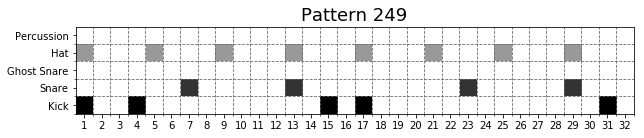

runtime: 1.235 seconds


In [26]:
import timeit

start = timeit.default_timer()

#constraints is a boolean list indicating which rules to include in the problem.
#It is in the following format:
# constraints = [[kick placement, kick mild constraints, kick moderate constraints], 
#               [snare placement with mild constraints, snare placement with moderate constraints],
#               [kick snare additional constraints],
#               [hat placement w/ mild constraints, hat placement w/ moderate contraints, hat additional mild constraints, hat additional moderate constraints],
#               [percussion placement, percussion mild constraints, percussion moderate constraints]
#               [ghost snare placement, ghost snare mild constraints, ghost snare moderate constraints], 
#               [2 bar pattern]]

constraints = [ [True, True, True], \
                [False, True], \
                [True], \
                [False, True, True, True], \
                [True, True, True], \
                [True, True, True] ]

#Patterns will be filled out around any user input given to the program.
#user_input = ["chooseHit(k, 3).", "chooseHit(s, 5).", "chooseHit(s, 13)."]

generate_patterns(constraints, 1, 2, 0.01)

stop = timeit.default_timer()

runtime = stop - start

print("runtime: " + str(round(runtime, 3)) + " seconds") 